<a href="https://colab.research.google.com/github/tomhyhan/noodles/blob/main/pasta_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import userdata
from google.colab import auth

auth.authenticate_user()
token = userdata.get('token')
username = userdata.get('username')
repo_name = "noodles"

In [37]:
import os

!git clone https://github.com/tomhyhan/{repo_name}.git

if os.getcwd() != f"/content/{repo_name}":
    %cd {repo_name}
!git pull
!pwd


fatal: destination path 'noodles' already exists and is not an empty directory.
From https://github.com/tomhyhan/noodles
   4246343..6bf737e  main       -> origin/main
Already up to date.
/content/noodles


In [6]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "noodles"

GOOGLE_DRIVE_PATH = os.path.join("..", "drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


In [8]:
from model.utils import test_colab
test_colab()


Hello Colab! from Noodles ha


In [9]:
!pip install torchinfo
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 79.0 MB/s eta 0:00:00


In [23]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold


from config.config_manager import ConfigManager
from collections import Counter
from model.data_model import PastaData, create_train_transforms, create_test_transforms
from model.train import trainer, create_model
from model.utils import reset_seed
from model.data import CLASS_ENCODER, create_csv
from model.viz import class_imbalance, draw_loss, draw_train_val_accuracy

In [24]:
config_manager = ConfigManager("./config/config.yml")

SEED = config_manager.config.seed

In [25]:
reset_seed(SEED)

In [26]:
image_path = os.path.join(GOOGLE_DRIVE_PATH, "images")
csv_file_path = os.path.join(GOOGLE_DRIVE_PATH, "pasta_data.csv")

if not os.path.exists(csv_file_path):
    create_csv(image_path, csv_file_path)

In [27]:
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "./pasta_data.csv"))
image_paths, labels = data["img_path"], data["label"]

X, test_data, y, test_label = train_test_split(image_paths.values, labels.values, train_size=0.9, random_state=SEED, shuffle=True, stratify=labels)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


80 20


Epoch 1/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [0.0001]
Epoch 1 Loss: 2.7834676106770835 Train Accuracy: 0.375             Validation Accuracy: 0.375
Global gradient norm: 13.055885901348809


Epoch 2/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [0.0001]
Epoch 2 Loss: 2.18021240234375 Train Accuracy: 0.7208333333333333             Validation Accuracy: 0.25
Global gradient norm: 15.70924005179063


Epoch 3/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [0.0001]
Epoch 3 Loss: 1.2519331614176432 Train Accuracy: 0.95             Validation Accuracy: 0.375
Global gradient norm: 22.878301955823847


Epoch 4/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [0.0001]
Epoch 4 Loss: 0.6160331885019938 Train Accuracy: 0.9958333333333333             Validation Accuracy: 0.375
Global gradient norm: 22.693009935197484


Epoch 5/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [2e-05]
Epoch 5 Loss: 0.3130719343821208 Train Accuracy: 0.9958333333333333             Validation Accuracy: 0.375
Global gradient norm: 13.549046326784483
End of Training for swin Model 0-fold
best accuracy: 0.375


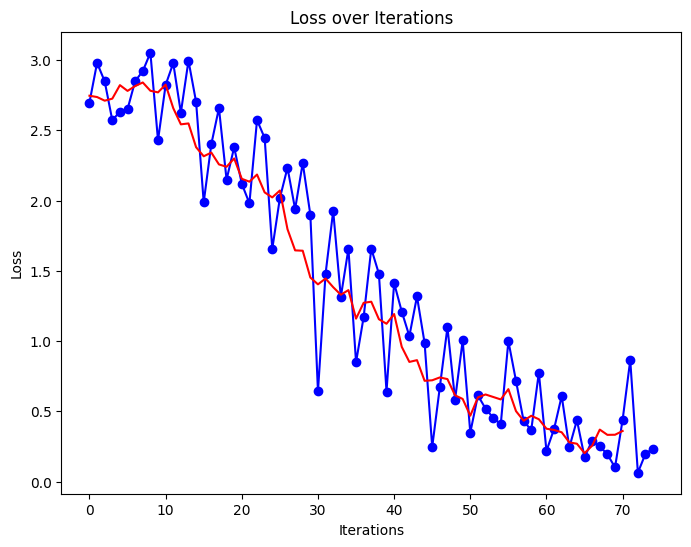

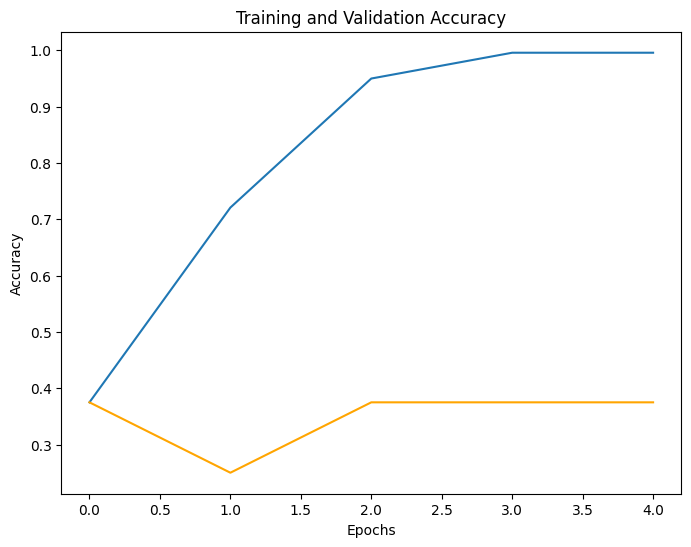

current_model_accuracies [0.375]


In [35]:
k_fold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
models = ['swin']

N=100
perm_indices = np.random.permutation(N)
X = X[perm_indices]
y = y[perm_indices]

for model_name in models:
    current_model_accuracies = []
    for k_id, (train_i, val_i) in enumerate(k_fold.split(X,y)):
        print(len(train_i), len(val_i))
        train_set = X[train_i]
        train_label_set = y[train_i]

        val_set = X[val_i]
        val_label_set = y[val_i]

        model_config = config_manager.config[model_name]
        lr = config_manager.config.lr
        num_epochs = config_manager.config.num_epochs
        num_classes = config_manager.config.num_classes
        batch_size = model_config.train_args.batch_size
        weight_decay = model_config.train_args.weight_decay
        log_interval = model_config.train_args.log_interval
        out_dir = model_config.train_args.output_dir
        scheduler_name = model_config.train_args.scheduler

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_transform = create_train_transforms()
        test_transform = create_test_transforms()

        train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
        val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

        model = create_model(model_name, num_classes)
        model.to(device)

        #  need to make dataframe from images
        loss_history, train_accuracy_history, \
        val_accuracy_history, best_accuracy, best_params = trainer(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            log_interval=log_interval,
            # scheduler_name=scheduler_name,
            device=device
        )


        current_model_accuracies.append(best_accuracy)
        print(f"End of Training for {model_name} Model {k_id}-fold")
        print(f"best accuracy: {best_accuracy}")

        os.makedirs(os.path.join(GOOGLE_DRIVE_PATH, out_dir), exist_ok=True)
        torch.save(best_params, os.path.join(GOOGLE_DRIVE_PATH, out_dir, f"{model_name}_k_fold_{k_id}.pt"))
        draw_loss(loss_history)
        draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)

        break

    print("current_model_accuracies", current_model_accuracies)
    break


        # avg_accuracy = torch.mean(fold_accuracies)
        # std_accuracy = torch.std(fold_accuracies)

        # general plan
        # 1. save best accuracies
        # 2. compare with different models
        # 3. train on full dataset with best performing model
        # 4. make inference


In [ ]:
# Inference

In [36]:
# !git config pull.rebase false
!git pull
!git config --global user.email "tomhyhan@gmail.com"
!git config --global user.name username
!git add .
!git status
!git commit -m "updated trainer"
!git push https://{token}@github.com/{username}/{repo_name}.git

Already up to date.
hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> noodles
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached noodles
hint: 
hint: See "git help submodule" for more information.
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   config/config.yml
	modified:   model/train.py
	new file:   noodles

[main 6bf737e] updated trainer
 3 files changed, 27 insertions(+), 11 deletions(-)
 create mode 160000 noodles
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing ob